In [66]:
import pandas as pd
import seaborn as sns

%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import scipy

In [2]:
df_initial = pd.read_csv('gnewt_morning_10feb.csv', delimiter=';')
df_initial.head().T

,0,1,2,3,4
altitude,0,0,0,0,0
co_a,267.5,267.5,265.9,265.9,270.8
co_w,191.8,190.2,192.6,191.8,191
pt,0,0,0,0,0
gps_fix,0,0,0,0,0
heading,0,0,0,0,0
humidity,14.1,14.1,14.1,14.1,14.1
latitude,0,0,0,0,0
lonet_bat,0,0,0,0,0
longitude,0,0,0,0,0


Readings seem to stabilize at 22:00, before that they fluctuated wildly.

In [3]:
# filter by time
def filter_by_time(df):
    time = (df.timestamp >= '2017-02-09 22:00') & (df.timestamp <= '2017-02-10 12:00')
    return df[time]

df_initial.timestamp = pd.to_datetime(df_initial.timestamp)
df = filter_by_time(df_initial)
df = df.sort_values(by='timestamp')
df = df.set_index('timestamp')

In [4]:
# load calibration sheet from jukka
cal = pd.read_csv('V0_3_calibration.csv', index_col='ID')
cal = cal.T
# load fudge factors from colocation
colocation = pd.DataFrame(pd.read_csv('../alphasense_fudge_factors.csv', index_col=0))
colocation = colocation.T

# CO Conversion

## Alphasense

### Conversion to ppb

In [5]:
def convert_co_ID(ID, CO_working_mv, CO_aux_mv, temp_correction = +1):
    # temp corretion is +1 up to 20 deg Cels, then -1, then -0.7 after 30C
    CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = cal[ID].CO_WE_ELECTRONIC_ZERO
    CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = cal[ID].CO_AUX_ELECTRONIC_ZERO
    #CO_SENSITIVITY = cal.loc[cal['ID'] == ID].CO_SENSITIVITY_mV_ppb; # mv/ppb
    CO_SENSITIVITY = cal[ID].CO_SENSITIVITY_nA_ppb; # nA/ppb
    CO_GAIN = cal[ID].CO_PCB_GAIN;

    scaled_working = (CO_working_mv - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)/CO_GAIN
    
    scaled_aux =  (CO_aux_mv - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / CO_GAIN*temp_correction
    
    return  (scaled_working - scaled_aux)/CO_SENSITIVITY

In [6]:
df['co_ppb_alphasense'] = df[['id', 'co_a', 'co_w']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)

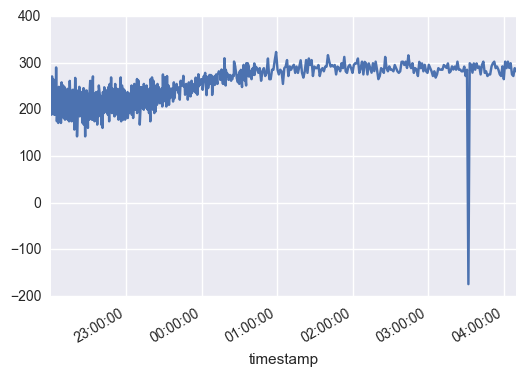

In [7]:
df.co_ppb_alphasense.plot()

In [8]:
# try using previous formula without torching calibration to see whether it makes a huge difference
def convert_co(CO_working_mv=None, CO_aux_mv=None, temp_correction = +1):
    ANALOG_REF_VOLTAGE = 3.3;
    
    # AFE board serial number 12-000027
    # sensor CO A4 serial number 132950238

    CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 268;
    CO_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 42;

    CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 262;
    CO_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 10;
    CO_SENSITIVITY = 0.285; # mv/ppb
    
    scaled_working_CO_nA = (CO_working_mv - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV) / 0.8
    scaled_aux_CO_nA  =  (CO_aux_mv - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / 0.8 * temp_correction
    return (scaled_working_CO_nA - scaled_aux_CO_nA) / CO_SENSITIVITY

In [9]:
df['co_ppb_alphasense_no_cal'] = df[['co_a', 'co_w']].apply(lambda x: convert_co(x.values[0], x.values[1]), axis=1)

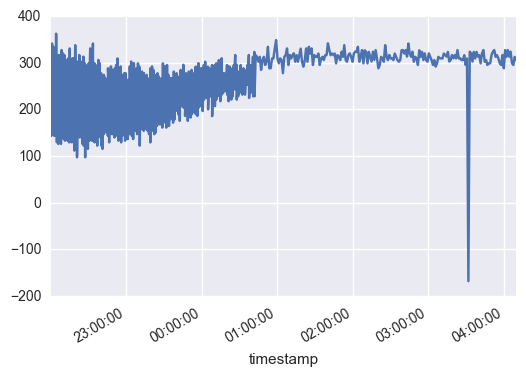

In [10]:
df.co_ppb_alphasense_no_cal.plot()

### Different sensor boxes

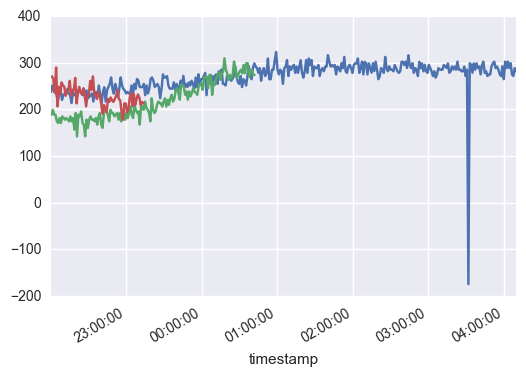

In [11]:
alphasense_co_df = pd.DataFrame()
for sensor_id in df.id.unique():
    select_df = df[df.id == sensor_id]
    temp = pd.DataFrame({sensor_id: select_df.co_ppb_alphasense})
    alphasense_co_df = pd.concat([alphasense_co_df, temp], axis=1)

# reorder columns
columns = np.sort(alphasense_co_df.columns.values)
alphasense_co_df = alphasense_co_df[columns]
for col in alphasense_co_df:
    alphasense_co_df[col].dropna().plot()

### Filter out extreme values

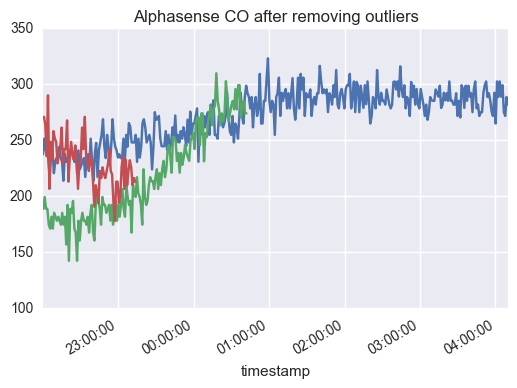

In [12]:
def remove_outliers(df, col):
    new_df = df.copy()
    outliers = (new_df[col] - new_df[col].median()).abs() > 3 * new_df[col].std()
    new_df.ix[new_df[col].notnull() & outliers, col] = new_df[col].mean()
    return new_df

alphasense_co_filter_outliers = alphasense_co_df.copy()
for column in alphasense_co_df.columns:
    alphasense_co_filter_outliers = remove_outliers(alphasense_co_filter_outliers, column)

for col in alphasense_co_filter_outliers.columns:
    alphasense_co_filter_outliers[col].dropna().plot()
    
plt.title("Alphasense CO after removing outliers")
alphasense_co_df = alphasense_co_filter_outliers

### 10 min averages

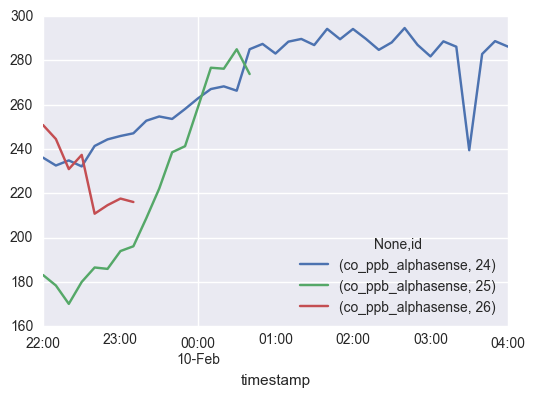

In [13]:
ds = xr.Dataset.from_dataframe(df.set_index(['id'], append=True))
ds_mean_1h = ds.resample(freq='10Min', dim='timestamp', how='mean', skipna=True)
# df.co_ppb_alphasense.plot(linestyle='none', marker='o')
# df.co_ppb_alphasense.plot()
ds_mean_1h.co_ppb_alphasense.to_dataframe().unstack(level=1).plot()

### Correlation between different alphasense sensors

In [14]:
alphasense_co_df = pd.DataFrame()
for sensor_id in df.id.unique():
    select_df = df[df.id == sensor_id]
    temp = pd.DataFrame({sensor_id: select_df.co_ppb_alphasense})
    alphasense_co_df = pd.concat([alphasense_co_df, temp], axis=1)

# reorder columns
columns = np.sort(alphasense_co_df.columns.values)
alphasense_co_df = alphasense_co_df[columns]

In [15]:
# get 10 min average
alphasense_co_ds = xr.Dataset.from_dataframe(alphasense_co_df)
co_ds_mean = alphasense_co_ds.resample(freq='10Min', dim='timestamp', how='mean', skipna=True)

In [16]:
# pearson's correlation
co_ds_mean.to_dataframe().corr()

,24,25,26
24,1.000000,0.930913,-0.814703
25,0.930913,1.000000,-0.565336
26,-0.814703,-0.565336,1.000000


## MICS

### Conversion to ppb

In [32]:
# need calibration to determine r0
def convert_co_mics(v_out, r_0=150e3, r_1=1e6, vs=5.0*1000):
    # read some values off the graph for CO
    x = np.array([2., 10., 100.])
    y = np.array([2., 0.4, 0.06])
    m, c= np.polyfit(np.log10(y), np.log10(x), 1)
    
    # convert voltage to resistance    
    rs = r_1 / ((vs/v_out) - 1.0)
    # + 3 is to convert from ppm to ppb
    return 10.**(c + 3) * (rs / r_0)**m

df['co_ppb_mics'] = convert_co_mics(df.m_co)

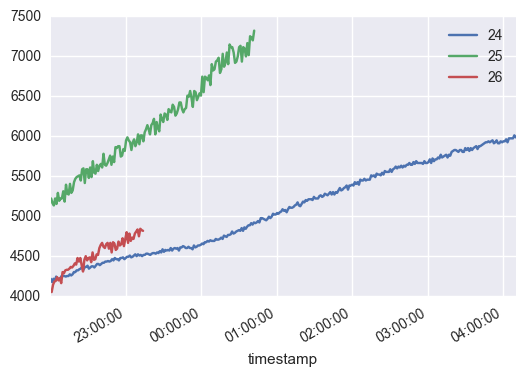

In [33]:
mics_co_df = pd.DataFrame()
for sensor_id in df.id.unique():
    select_df = df[df.id == sensor_id]
    temp = pd.DataFrame({sensor_id: select_df.co_ppb_mics})
    mics_co_df = pd.concat([mics_co_df, temp], axis=1)

# reorder columns
columns = np.sort(mics_co_df.columns.values)
mics_co_df = mics_co_df[columns]
for col in mics_co_df.columns:
    mics_co_df[col].dropna().plot(label=col)
plt.legend()

This is very high compared to alphasense, but looking at the data sheet it makes sense, because the typical CO detection range is 1 - 1000ppm, so there's no way it's going to detect a alphasense value of ~200ppb. 

### Correlation between different MICS sensors

In [19]:
# get 10 min average
mics_co_ds = xr.Dataset.from_dataframe(mics_co_df)
mics_co_ds_mean = mics_co_ds.resample(freq='10Min', dim='timestamp', how='mean', skipna=True)
# mics correlation amongst mics sensors
mics_co_ds_mean.to_dataframe().corr()

,24,25,26
24,1.000000,0.988922,0.991045
25,0.988922,1.000000,0.989074
26,0.991045,0.989074,1.000000


## Correlation between alphasense and MICS

In [20]:
# correlation between alphasense and mics sensors
np.abs(mics_co_df.corrwith(alphasense_co_df))

24    0.482405
25    0.919358
26    0.646382
dtype: float64

## Smoothing out spikes
WIP: try different ways of smoothing out spikes and see which returns the best correlation coefficient

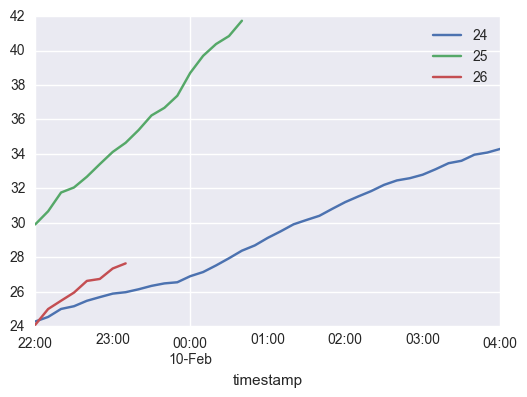

In [21]:
mics_co_ds_mean.to_dataframe().plot()

# NO2 conversion

## Alphasense

### Conversion to ppb

In [22]:
def convert_no2_ID(ID, NO2_working_mv, NO2_aux_mv, temp_correction = +1.09):
    # For A4 sensors: temp corretion is +1.09 up to 20 deg Cels, then 1.35, then 3 after 30C
    
    NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = cal[ID].NO2_WE_ELECTRONIC_ZERO;
    NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = cal[ID].NO2_AUX_ELECTRONIC_ZERO;
    #NO2_SENSITIVITY = cal.loc[cal['ID'] == ID].NO2_SENSITIVITY_mV_ppb; # mv/ppb
    NO2_SENSITIVITY = cal[ID].NO2_SENSITIVITY_nA_ppb; # nA/ppb
    NO2_GAIN = cal[ID].NO2_PCB_GAIN;
    
    scaled_working = (NO2_working_mv - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)/NO2_GAIN
    
    scaled_aux =  (NO2_aux_mv - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / NO2_GAIN*temp_correction
        
    return  (scaled_working - scaled_aux)/NO2_SENSITIVITY

In [23]:
df['no2_ppb_alphasense'] = df[['id', 'no2_a', 'no2_w']].apply(lambda x: convert_no2_ID(x.values[0], x.values[1], x.values[2]), axis=1)

### Different sensor boxes

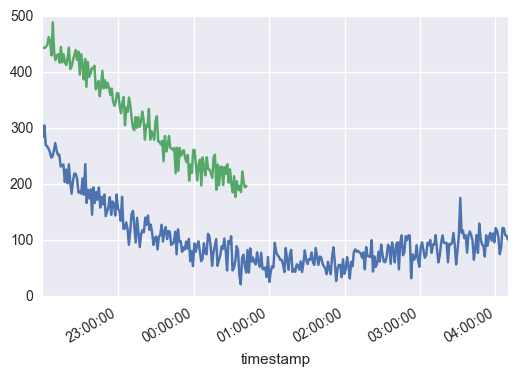

In [24]:
alphasense_no2_df = pd.DataFrame()
for sensor_id in df.id.unique():
    # NO2 aux is broken for box 26
    if sensor_id == 26:
        continue
    select_df = df[df.id == sensor_id]
    temp = pd.DataFrame({sensor_id: select_df.no2_ppb_alphasense})
    alphasense_no2_df = pd.concat([alphasense_no2_df, temp], axis=1)

# reorder columns
columns = np.sort(alphasense_no2_df.columns.values)
alphasense_no2_df = alphasense_no2_df[columns]
for col in alphasense_no2_df:
    alphasense_no2_df[col].dropna().plot()

### Correlation coefficient between diferent alphasense sensors

In [25]:
# get 10 min average
alphasense_no2_ds = xr.Dataset.from_dataframe(alphasense_no2_df)
no2_ds_mean = alphasense_no2_ds.resample(freq='10Min', dim='timestamp', how='mean', skipna=True)
no2_ds_mean.to_dataframe().corr()

,24,25
24,1.000000,0.972739
25,0.972739,1.000000


## Mics

### Conversion to ppb

In [47]:
# need calibration to determine r0
def convert_no2_mics(v_out, r_0=3e3, r_1=56e3, vs=5.0*1000):
    # read some values off the graph for NO2
    x = np.array([0.3, 0.6, 3.])
    y = np.array([2., 4., 11.])
    m, c = np.polyfit(np.log10(y), np.log10(x), 1)
    
    rs = r_1 / ((vs/v_out) - 1.0)
    # + 3 is to convert from ppm to ppb
    return 10.**(c + 3) * (rs / r_0)**m

df['no2_ppb_mics'] = convert_no2_mics(df.m_co)

### Different sensor boxes

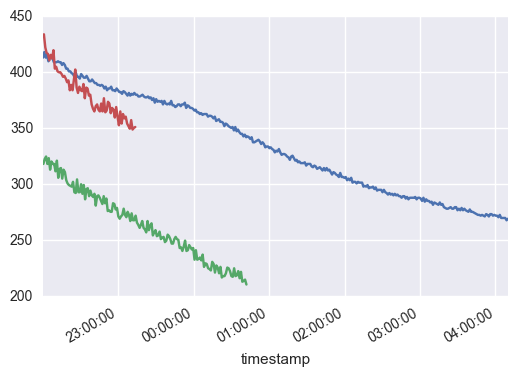

In [49]:
mics_no2_df = pd.DataFrame()
for sensor_id in df.id.unique():
    # NO2 aux is broken for box 26
#     if sensor_id == 26:
#         continue
    select_df = df[df.id == sensor_id]
    temp = pd.DataFrame({sensor_id: select_df.no2_ppb_mics})
    mics_no2_df = pd.concat([mics_no2_df, temp], axis=1)

# reorder columns
columns = np.sort(mics_no2_df.columns.values)
mics_no2_df = mics_no2_df[columns]
for col in mics_no2_df:
    mics_no2_df[col].dropna().plot()

In [52]:
# get 10 min average
mics_no2_ds = xr.Dataset.from_dataframe(mics_no2_df)
mics_no2_ds_mean = mics_no2_ds.resample(freq='10Min', dim='timestamp', how='mean', skipna=True)
mics_no2_ds_mean.to_dataframe().corr()

,24,25,26
24,1.000000,0.989307,0.990353
25,0.989307,1.000000,0.989085
26,0.990353,0.989085,1.000000


## Compare alphasense and MICS NO2

In [81]:
np.abs(mics_no2_df.corrwith(alphasense_no2_df))

24    0.617062
25    0.963176
26         NaN
dtype: float64